# NYC Subway Time Series Classification
Problem: Predicting whether traffic of passengers in a neighborhood at a specific point in time will be 'High' or 'Low'

#### Import Libraries & Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json

In [11]:
from google.colab import drive
drive.mount('/content/drive')a

Mounted at /content/drive


In [12]:
df=pd.read_csv('drive/MyDrive/PyTorch Hackathon 2021/dataset/baseline_binned.csv')

In [13]:
df.head()

,Neighborhood,Datetime,Area (in sq miles),Car-free commute (% of commuters),Disabled population,Foreign-born population,Mean travel time to work (minutes),Median household income (2018$),"Median rent, all (2018$)",num_of_stations,Percent Asian,Percent Hispanic,Percent black,Percent white,Population,"Population density (1,000 persons per square mile)",Poverty rate,Public housing (% of rental units),Rental vacancy rate,Residential units within 12 mile of a subway station,"Serious crime rate (per 1,000 residents)",Severely rent-burdened households,Unemployment rate,Privileged: Higher Percent white,Privileged: Higher Median household income (2018$),Privileged: Lower Percent Asian,Privileged: Lower Percent Hispanic,Privileged: Lower Percent black,Privileged: Lower Foreign-born population,Privileged: Lower Poverty rate,Privileged: Lower Unemployment rate,Privileged: Lower Severely rent-burdened households,"Privileged: Lower Serious crime rate (per 1,000 residents)",Privileged: Lower Disabled population,Division_BMT,Division_IND,Division_IRT,Structure_At Grade,Structure_Elevated,Structure_Open Cut,Structure_Subway,Structure_Viaduct,Borough_Bk,Borough_Bx,Borough_M,Borough_Q,ConnectingLine_N,ConnectingLine_Q,ConnectingLine_R,ConnectingLine_D,ConnectingLine_B,ConnectingLine_F,ConnectingLine_M,ConnectingLine_A,ConnectingLine_C,ConnectingLine_E,ConnectingLine_S,ConnectingLine_J,ConnectingLine_Z,ConnectingLine_1,ConnectingLine_2,ConnectingLine_3,ConnectingLine_L,ConnectingLine_G,ConnectingLine_5,ConnectingLine_4,ConnectingLine_7,ConnectingLine_6,binary_target
0,Astoria,1/4/2020 0:00,5.151129,81.6,4.6,36.8,42.0,67650,1670,12,16.7,24.3,8.2,47.5,164321,31.9,13.0,10.3,2.3,72.9,8.1,23.9,4.61,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Astoria,1/4/2020 4:00,5.151129,81.6,4.6,36.8,42.0,67650,1670,12,16.7,24.3,8.2,47.5,164321,31.9,13.0,10.3,2.3,72.9,8.1,23.9,4.61,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Astoria,1/4/2020 8:00,5.151129,81.6,4.6,36.8,42.0,67650,1670,12,16.7,24.3,8.2,47.5,164321,31.9,13.0,10.3,2.3,72.9,8.1,23.9,4.61,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Astoria,1/4/2020 12:00,5.151129,81.6,4.6,36.8,42.0,67650,1670,12,16.7,24.3,8.2,47.5,164321,31.9,13.0,10.3,2.3,72.9,8.1,23.9,4.61,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Astoria,1/4/2020 16:00,5.151129,81.6,4.6,36.8,42.0,67650,1670,12,16.7,24.3,8.2,47.5,164321,31.9,13.0,10.3,2.3,72.9,8.1,23.9,4.61,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
categorical_features = ['Neighborhood']

numerical_features = ['Area (in sq miles)',
                      'Car-free commute (% of commuters)',
                      'Disabled population',
                      'Foreign-born population',
                      'Mean travel time to work (minutes)',
                      'Median household income (2018$)',
                      'Median rent, all (2018$)',
                      'num_of_stations',
                      'Percent Asian', 
                      'Percent Hispanic', 
                      'Percent black', 
                      'Percent white',
                      'Population', 
                      'Population density (1,000 persons per square mile)',
                      'Poverty rate', 
                      'Public housing (% of rental units)',
                      'Rental vacancy rate',
                      'Residential units within 12 mile of a subway station',
                      'Serious crime rate (per 1,000 residents)',
                      'Severely rent-burdened households', 
                      'Unemployment rate']


stations = ['Division_BMT','Division_IND', 'Division_IRT', 'Structure_At Grade',
            'Structure_Elevated', 'Structure_Open Cut', 'Structure_Subway',
            'Structure_Viaduct', 'Borough_Bk', 'Borough_Bx', 'Borough_M',
            'Borough_Q', 'ConnectingLine_N', 'ConnectingLine_Q', 'ConnectingLine_R',
            'ConnectingLine_D', 'ConnectingLine_B',
            'ConnectingLine_F', 'ConnectingLine_M', 'ConnectingLine_A',
            'ConnectingLine_C', 'ConnectingLine_E', 'ConnectingLine_S',
            'ConnectingLine_J', 'ConnectingLine_Z', 'ConnectingLine_1',
            'ConnectingLine_2', 'ConnectingLine_3', 'ConnectingLine_L',
            'ConnectingLine_G', 'ConnectingLine_5', 'ConnectingLine_4',
            'ConnectingLine_7', 'ConnectingLine_6']

time = ["day_of_week", "day", "hour"]

feature_list = categorical_features + time + numerical_features + stations

label = ['binary_target']

In [15]:
df.shape

(27846, 69)

### Data Preparation

*   Generation of time-based features (day, day of week, hour)
*   Min-max transformation of numerical features (fit on train and transform on both)
*   Label encoding of categorical feature (Neighborhood) - for input into Embedding Layer









In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

columns_to_minmax = numerical_features + time

scaler = MinMaxScaler().fit(df[[*columns_to_minmax]])
df[[*columns_to_minmax]] = scaler.transform(df[[*columns_to_minmax]])

In [ ]:
# to feed into embedding layer

columns_to_le = categorical_features

le = LabelEncoder()
df[[*columns_to_le]] = le.fit_transform(df[[*columns_to_le]])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df.head()

,Neighborhood,Datetime,Area (in sq miles),Car-free commute (% of commuters),Disabled population,Foreign-born population,Mean travel time to work (minutes),Median household income (2018$),"Median rent, all (2018$)",num_of_stations,Percent Asian,Percent Hispanic,Percent black,Percent white,Population,"Population density (1,000 persons per square mile)",Poverty rate,Public housing (% of rental units),Rental vacancy rate,Residential units within 12 mile of a subway station,"Serious crime rate (per 1,000 residents)",Severely rent-burdened households,Unemployment rate,Privileged: Higher Percent white,Privileged: Higher Median household income (2018$),Privileged: Lower Percent Asian,Privileged: Lower Percent Hispanic,Privileged: Lower Percent black,Privileged: Lower Foreign-born population,Privileged: Lower Poverty rate,Privileged: Lower Unemployment rate,Privileged: Lower Severely rent-burdened households,"Privileged: Lower Serious crime rate (per 1,000 residents)",Privileged: Lower Disabled population,Division_BMT,Division_IND,Division_IRT,Structure_At Grade,Structure_Elevated,Structure_Open Cut,Structure_Subway,Structure_Viaduct,Borough_Bk,Borough_Bx,Borough_M,Borough_Q,ConnectingLine_N,ConnectingLine_Q,ConnectingLine_R,ConnectingLine_D,ConnectingLine_B,ConnectingLine_F,ConnectingLine_M,ConnectingLine_A,ConnectingLine_C,ConnectingLine_E,ConnectingLine_S,ConnectingLine_J,ConnectingLine_Z,ConnectingLine_1,ConnectingLine_2,ConnectingLine_3,ConnectingLine_L,ConnectingLine_G,ConnectingLine_5,ConnectingLine_4,ConnectingLine_7,ConnectingLine_6,binary_target,day_of_week,day,hour
0,0,2020-01-04 00:00:00,0.203706,0.828729,0.151042,0.424628,0.629921,0.370157,0.450292,0.458333,0.302583,0.27193,0.084687,0.631793,0.354975,0.219136,0.181102,0.19619,0.145161,0.70187,0.189474,0.246528,0.134584,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.833333,0.0,0.0
1,0,2020-01-04 04:00:00,0.203706,0.828729,0.151042,0.424628,0.629921,0.370157,0.450292,0.458333,0.302583,0.27193,0.084687,0.631793,0.354975,0.219136,0.181102,0.19619,0.145161,0.70187,0.189474,0.246528,0.134584,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.833333,0.0,0.2
2,0,2020-01-04 08:00:00,0.203706,0.828729,0.151042,0.424628,0.629921,0.370157,0.450292,0.458333,0.302583,0.27193,0.084687,0.631793,0.354975,0.219136,0.181102,0.19619,0.145161,0.70187,0.189474,0.246528,0.134584,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.833333,0.0,0.4
3,0,2020-01-04 12:00:00,0.203706,0.828729,0.151042,0.424628,0.629921,0.370157,0.450292,0.458333,0.302583,0.27193,0.084687,0.631793,0.354975,0.219136,0.181102,0.19619,0.145161,0.70187,0.189474,0.246528,0.134584,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.833333,0.0,0.6
4,0,2020-01-04 16:00:00,0.203706,0.828729,0.151042,0.424628,0.629921,0.370157,0.450292,0.458333,0.302583,0.27193,0.084687,0.631793,0.354975,0.219136,0.181102,0.19619,0.145161,0.70187,0.189474,0.246528,0.134584,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.833333,0.0,0.8


### Timeseries Dataset & Data Loader

*   Train-Test split for timeseries data based on time, to avoid look ahead bias.



In [ ]:
def timeseries_train_test_split(df, time_column, val_size=0.2, test_size=0.1, drop_time_col=False):
    """
    Train-Test split for Timeseries data based on time, to avoid look ahead bias.
    :param df: Pandas df
    :param time_column: Column name of timestamp, to generate split by
    :param val_size: Size of validation dataset
    :param test_size: Size of test dataset
    :param drop_time_col: Boolean option of dropping time column from generated train/val/test dataframes, default False
    :return train_df: Pandas dataframe for training data
    :return val_df: Pandas dataframe for validation data
    :retrun test_df: Pandas dataframe for test data
    """
    timesteps = df[time_column].unique()
    length = len(timesteps)
    train_timesteps = timesteps[: int(np.ceil(length*(1-val_size-test_size)))]
    val_timesteps = timesteps[int(np.ceil(length*(1-val_size-test_size))) : int(np.ceil(length*(1-test_size)))]
    test_timesteps = timesteps[int(np.ceil(length*(1-test_size))):]

    train_df = df[df[time_column].isin(train_timesteps)]
    val_df = df[df[time_column].isin(val_timesteps)]
    test_df = df[df[time_column].isin(test_timesteps)]

    if drop_time_col:
      train_df = train_df.drop(time_column, axis=1)
      val_df = val_df.drop(time_column, axis=1)
      test_df = test_df.drop(time_column, axis=1)

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = timeseries_train_test_split(df, 'Datetime', val_size=0.2, test_size=0.1, drop_time_col=True)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((19533, 71), (5559, 71), (2754, 71))

In [ ]:
def df_to_tensor(df):
    x1 = np.array(df[[*categorical_features]]).astype(int) 
    x2 = np.array(df[[*(time + numerical_features + stations)]])
    y = np.array(df[label])

    x1_ts = torch.Tensor(x1).type(torch.LongTensor)
    x2_ts = torch.Tensor(x2)
    y_ts = torch.Tensor(y)

    return x1_ts, x2_ts, y_ts

In [ ]:
x1_train_ts, x2_train_ts, y_train_ts = df_to_tensor(train_df)
x1_val_ts, x2_val_ts, y_val_ts = df_to_tensor(val_df)
x1_test_ts, x2_test_ts, y_test_ts = df_to_tensor(test_df)

In [ ]:
x1_train_ts.shape, x2_train_ts.shape, y_train_ts.shape, x1_val_ts.shape, x2_val_ts.shape, y_val_ts.shape, x1_test_ts.shape, x2_test_ts.shape, y_test_ts.shape

(torch.Size([19533, 1]),
 torch.Size([19533, 58]),
 torch.Size([19533, 1]),
 torch.Size([5559, 1]),
 torch.Size([5559, 58]),
 torch.Size([5559, 1]),
 torch.Size([2754, 1]),
 torch.Size([2754, 58]),
 torch.Size([2754, 1]))

In [ ]:
from torch.utils.data import TensorDataset,DataLoader
train_set = TensorDataset(x1_train_ts, x2_train_ts, y_train_ts)
val_set = TensorDataset(x1_val_ts,x2_val_ts,y_val_ts)

train_loader = DataLoader(train_set, batch_size = 32, shuffle = False)
val_loader = DataLoader(val_set, batch_size = 32, shuffle = False)

In [ ]:
### save testing dataset
test_df.to_csv('drive/MyDrive/PyTorch Hackathon 2021/models/1. base_model/baseline_1103.csv', index=False)

In [ ]:
### export feature_list
feature_dict = {'x1': categorical_features, 'x2': time + numerical_features + stations, 'y': label}

In [ ]:
FEATURE_DICT = 'drive/MyDrive/PyTorch Hackathon 2021/datasets/feature_dict.json'
with open(FEATURE_DICT, 'w') as file:
     file.write(json.dumps(feature_dict))

### Model Architecture

 MultiInputNet - multiple input neural network architecture, to treat each type of feature differently

In [ ]:
from torch import nn,optim
class  MultiInputNet(nn.Module):
    """Multiple input model - FFN + an embedding layer for neighborhood """
    def __init__(self, x1_size, x2_size, vocab_size, embed_dim, hidden_size_1, hidden_size_2, num_classes):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size,embed_dim)
        self.fc1 = nn.Linear(x2_size, hidden_size_1)
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(hidden_size_1 + embed_dim, hidden_size_2)
        self.relu = nn.ReLU() 
        self.fc3 = nn.Linear(hidden_size_2,num_classes)

    def forward(self, x1, x2):
        x1 = self.embeddings(x1)
        x1 = torch.squeeze(x1)
        x2 = self.fc1(x2)
        x2 = self.relu(x2)
        x = torch.cat((x1, x2),dim=1)
        x = self.fc2(x)
        x = self.relu(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 1 # binary

x1_size = x1_train_ts.shape[1]
x2_size = x2_train_ts.shape[1]

# Embedding
vocab_size = len(df['Neighborhood'].unique())
embed_dim = hidden_size_1 = 10

# FFN
hidden_size_2 = 10

base_model = MultiInputNet(x1_size,
                          x2_size,
                          vocab_size,
                          embed_dim,
                          hidden_size_1,
                          hidden_size_2,
                          num_classes).to(device)
print(base_model)

MultiInputNet(
  (embeddings): Embedding(51, 10)
  (fc1): Linear(in_features=58, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


### Model Training


In [ ]:
NUM_EPOCHS = 100
lr = 0.005
criterion = nn.BCELoss()
optimizer = optim.SGD(base_model.parameters(), lr=lr)

In [ ]:
def make_train_step(net, criterion, optimizer):

  def train_step(inputs, labels):

    optimizer.zero_grad()
    outputs = net(*inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    return loss.item()
    
  return train_step


def make_val_step(net, criterion):

  def val_step(x, y):
    net.eval()

    y_hat = net(*x)
    val_loss = criterion(y_hat, y)

    return val_loss.item()

  return val_step

In [ ]:
train_step = make_train_step(base_model, criterion, optimizer)
val_step = make_val_step(base_model, criterion)

losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
  running_loss = 0.0
  running_val_loss = 0.0

  for i, (x1, x2, y) in enumerate(train_loader):
    x1 = x1.to(device)
    x2 = x2.to(device)
    y = y.to(device)

    loss = train_step([x1, x2], y)
    running_loss += loss

  with torch.no_grad():
    for i, (x1, x2, y) in enumerate(val_loader):
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)

        val_loss = val_step([x1, x2], y)
        running_val_loss += val_loss

  epoch_loss = running_loss / len(train_loader)
  epoch_val_loss = running_val_loss / len(val_loader)
  print('Epoch: %d, training loss: %.3f, val loss: %.3f'%(epoch+1,epoch_loss,epoch_val_loss))

  losses.append(epoch_loss)
  val_losses.append(epoch_val_loss)

print('Finished Training')

Epoch: 1, training loss: 0.700, val loss: 0.685
Epoch: 2, training loss: 0.666, val loss: 0.655
Epoch: 3, training loss: 0.615, val loss: 0.597
Epoch: 4, training loss: 0.536, val loss: 0.528
Epoch: 5, training loss: 0.458, val loss: 0.483
Epoch: 6, training loss: 0.407, val loss: 0.459
Epoch: 7, training loss: 0.374, val loss: 0.445
Epoch: 8, training loss: 0.349, val loss: 0.433
Epoch: 9, training loss: 0.332, val loss: 0.423
Epoch: 10, training loss: 0.319, val loss: 0.413
Epoch: 11, training loss: 0.309, val loss: 0.404
Epoch: 12, training loss: 0.300, val loss: 0.396
Epoch: 13, training loss: 0.293, val loss: 0.389
Epoch: 14, training loss: 0.287, val loss: 0.383
Epoch: 15, training loss: 0.281, val loss: 0.377
Epoch: 16, training loss: 0.276, val loss: 0.371
Epoch: 17, training loss: 0.272, val loss: 0.366
Epoch: 18, training loss: 0.268, val loss: 0.361
Epoch: 19, training loss: 0.265, val loss: 0.357
Epoch: 20, training loss: 0.262, val loss: 0.352
Epoch: 21, training loss: 0.2

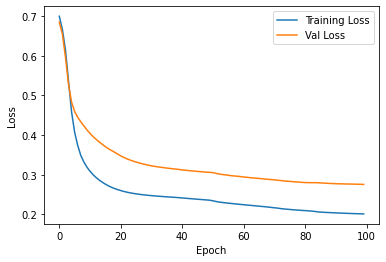

In [ ]:
plt.plot(losses)
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.show()

In [ ]:
from torch import jit
# exporting model to Torchscript using tracing
# https://discuss.pytorch.org/t/how-to-load-using-torch-load-without-source-class-using-which-model-was-created/75302
PATH = 'drive/My Drive/PyTorch Hackathon 2021/models/1. base_model/baseline_1103.pt'
net_trace = jit.trace(base_model, (x1, x2))
jit.save(net_trace, PATH)

### Model Inference & Eval

In [ ]:
model = torch.jit.load(PATH)

In [ ]:
with torch.no_grad():
  model.eval()
  pred_proba = model(x1_test_ts, x2_test_ts)

In [ ]:
# get y_test and y_pred np arrays for sklearn metric eval
y_pred = [1 if i >= 0.5 else 0 for i in pred_proba]
y_test = y_test_ts.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score,confusion_matrix,roc_auc_score,classification_report
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.8631082062454611
0.8630911680911681


In [ ]:
roc_auc_score(y_test, pred_proba)

0.940301255671626

In [ ]:
confusion_matrix(y_test, y_pred)

array([[1188,  162],
       [ 228, 1176]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      1350
         1.0       0.88      0.84      0.86      1404

    accuracy                           0.86      2754
   macro avg       0.86      0.86      0.86      2754
weighted avg       0.86      0.86      0.86      2754



In [ ]:
pred_df = test_df
pred_df['binary_target_prediction'] = y_pred

In [ ]:
pred_df.to_csv('drive/MyDrive/PyTorch Hackathon 2021/dataset/pred_csv/pred_basemodel_1103.csv')